In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import h5py
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import trackpy as tp

In [14]:
# Define the Gaussian function with an additive background term
def gaussian_bg(x, mu, sigma, amplitude, background):
    return amplitude * np.exp(-((x - mu) / sigma)**2 / 2) + background
def gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-((x - mu) / sigma)**2 / 2)
# Generate some fake data to fit
x = np.linspace(-5, 5, num=50)
y = gaussian_bg(x, 0, 1, 1, 0.5) + np.random.normal(0, 0.2, size=50)
# Fit the data to the Gaussian function
params, cov = curve_fit(gaussian_bg, x, y)
# Extract the fitted parameters
mu, sigma, amplitude, background = params
print(f'Fit results: mu = {mu:.2f}, sigma = {sigma:.2f}, amplitude = {amplitude:.2f}, background = {background:.2f}')


Fit results: mu = -0.22, sigma = 1.05, amplitude = 1.01, background = 0.44


In [15]:
# Plectoneme
h5path = r"\\cifs1.bpcentral.biophys.mpg.de\msdata\kimlab\biswajit\tud_archive\data\20201216_plectonominDNA\S151d12Dec20-CH6_A3_50mW561nm_5msAqt_200nMSxO_analysis\Plectoneme.leads.hdf5"

# # nicked DNA
# h5path = r"\\cifs1.bpcentral.biophys.mpg.de\msdata\kimlab\biswajit\tud_archive\data\20201216_plectonominDNA\S151d12Dec20-CH6_A3_2mW561nm_100msAqt_analysis\dna.leads.hdf5"

# # # single tethered DNA
# h5path = r"E:\Data\20230713_JetABC_C1incub_1tether_analysis\20230713_CH2_DigBt_100NaCl_200SxO_50pM_wt_imgs_1_analysis\LoopedDNA (4).leads.hdf5"


with h5py.File(h5path, 'r') as h5:
    print(h5.keys())
    img_arr_0 = h5['img_arr_0'][:]
    print(h5['parameters'].keys())
    region_loop = h5['parameters']['region3_Loop'][:]
    dna_end = h5['parameters']['dna ends'][:]
    print(region_loop)
    print(h5['parameters']['Number of Colors'][...])

<KeysViewHDF5 ['DNA ends', 'Left Max Peaks', 'filepath', 'img_arr_0', 'kymo_0', 'kymo_0_loop', 'kymo_0_nonloop', 'manual_properties', 'msd_analysis', 'parameters', 'xtra_analysis']>
<KeysViewHDF5 ['Aquisition Time', 'MultiPeak', 'Number of Colors', 'Pixel Size', 'ROI width', 'Region Errbar', 'dna ends', 'filepath', 'folderpath', 'region3_Loop', 'region3_noLoop', 'roi1 state']>
[597.85075371 729.62138895]
1


(132, 75, 25)


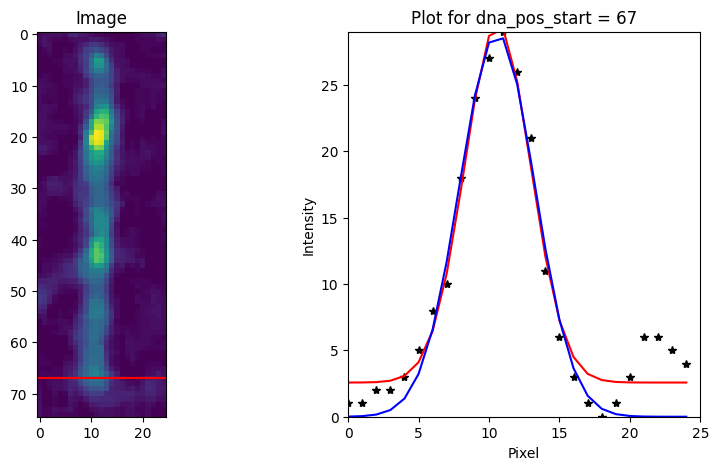

In [16]:
region_loop_0 = int(region_loop[0])
region_loop_1 = int(region_loop[1])
dna_pos_start = int(dna_end[0])
dna_pos_end = int(dna_end[1])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

img_arr_0_loop = img_arr_0[int(region_loop[0]):int(region_loop[1]), ::]
print(img_arr_0_loop.shape)

frame = 10
image = img_arr_0_loop[frame, ::]

axs[0].imshow(image)
axs[0].set_title('Image')
ax0line = axs[0].axhline(y=dna_pos_start, color='r')

from matplotlib.animation import FuncAnimation

# Define the update function for the animation
def update(i):
    # Update the value of dna_pos_start
    dna_pos_start = int(dna_end[0] + i)
    # Update the line position
    ax0line.set_ydata(dna_pos_start)
    # Clear the previous plot
    axs[1].cla()
    y = image[dna_pos_start, :]
    x = np.arange(0, len(y), 1)
    # Plot the new data
    axs[1].plot(x, y, 'k*')
    # Fit the data to the Gaussian function
    mu_0 = np.argmax(y)
    sigma_0 = 3
    amplitude_0 = np.max(y)
    background_0 = np.min(y)
    try:
        params, cov = curve_fit(gaussian_bg, x, y, p0=[mu_0, sigma_0, amplitude_0, background_0])
        mu, sigma, amplitude, background = params
        axs[1].plot(x, gaussian_bg(x, mu, sigma, amplitude, background), 'r-')
        params, cov = curve_fit(gaussian, x, y, p0=[mu_0, sigma_0, amplitude_0])
        mu, sigma, amplitude = params
        axs[1].plot(x, gaussian(x, mu, sigma, amplitude), 'b-')
        axs[1].set_title(f'Plot for dna_pos_start = {dna_pos_start}')
        axs[1].set_ylim([np.min(y), np.max(y)])
        axs[1].set_xlim([0, len(y)])
        axs[1].set_xlabel('Pixel')
        axs[1].set_ylabel('Intensity')
    except:
        print(f"Error occurred at dna_pos_start = {dna_pos_start}")
        pass

# Create the animation
ani = FuncAnimation(fig, update, frames=dna_pos_end-dna_pos_start, interval=100)
ani_filename = h5path[:-5] + '.mp4'
# ani.save('animation.mp4')
ani.save(ani_filename)

from IPython.display import HTML, Video
# Display the animation as HTML5 video
HTML(ani.to_jshtml())

# # Alternatively, save the animation as an mp4 file and display it using the Video class
# ani.save('animation.mp4')
# Video('animation.mp4')
Video(ani_filename)


In [17]:
import pandas as pd
img_arr_0_loop = img_arr_0[int(region_loop[0]):int(region_loop[1]), ::]
frame=0
image = img_arr_0_loop[frame, ::]

def fit_gaussian(image, frame, skip_dna_pixs=1):
    # create an empty dataframe
    df = pd.DataFrame(columns=['frame', 'mu', 'sigma', 'amplitude', 'background'])

    # loop through the frames and fit the data to the Gaussian function
    for i in range(0, image.shape[0], skip_dna_pixs):
        dna_pos = i
        y = image[i, :]
        x = np.arange(0, len(y), 1)
        # Fit the data to the Gaussian function
        mu_0 = np.argmax(y)
        sigma_0 = 3
        amplitude_0 = np.max(y)
        background_0 = np.min(y)
        try:
            params, cov = curve_fit(gaussian_bg, x, y, p0=[mu_0, sigma_0, amplitude_0, background_0])
            mu, sigma, amplitude, background = params
        except:
            # print(f"Error occurred at frame:{frame}, dna position = {i}")
            mu, sigma, amplitude, background = mu_0, sigma_0, amplitude_0, background_0
            pass

        # add the values to the dataframe
        df = pd.concat([df, pd.DataFrame({'frame': frame, 'dna_pos': [dna_pos], 'mu': [mu], 'sigma': [sigma], 'amplitude': [amplitude], 'background': [background]})], ignore_index=True)

    # return the dataframe
    return df
df = fit_gaussian(image, frame)
print(df)

   frame         mu     sigma  amplitude  background  dna_pos
0      0   9.089874  1.914207   5.117649    0.897779      0.0
1      0   9.687193  2.177371   7.398984    0.544697      1.0
2      0  10.983021  1.729507  10.651523    0.992927      2.0
3      0  11.493591  1.874965  15.531621    0.880154      3.0
4      0  12.013661  1.767556  24.038678    1.099764      4.0
..   ...        ...       ...        ...         ...      ...
70     0  10.850939  1.636405   8.706130    0.971547     70.0
71     0   3.538822  0.927463   2.133225    1.201627     71.0
72     0   3.500000  0.273363   9.263807    1.260870     72.0
73     0   3.762464  0.698495   2.955269    1.273027     73.0
74     0  15.898725  0.937275   2.628671    0.432968     74.0

[75 rows x 6 columns]


In [18]:
def fit_gaussian_all_frames(img_arr_0_loop, skip_dna_pixs=1):
    # create an empty dataframe
    df_combined = pd.DataFrame(columns=['frame', 'dna_pos', 'mu', 'sigma', 'amplitude', 'background'])
    

    # loop through the frames and concatenate the dataframes
    for frame in range(img_arr_0_loop.shape[0]):
        image = img_arr_0_loop[frame, ::]
        df = fit_gaussian(image, frame, skip_dna_pixs=skip_dna_pixs)
        df_combined = pd.concat([df_combined, df], ignore_index=True)
    # return the combined dataframe
    return df_combined


df_combined = fit_gaussian_all_frames(img_arr_0_loop, skip_dna_pixs=1)
import warnings
warnings.filterwarnings('ignore')

c:\Users\bipradha\AppData\Local\miniconda3\envs\leads-env\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\bipradha\AppData\Local\miniconda3\envs\leads-env\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\bipradha\AppData\Local\miniconda3\envs\leads-env\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
c:\Users\bipradha\AppData\Local\miniconda3\envs\leads-env\lib\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimate

In [19]:
print(df_combined.head())
print(df_combined.tail())

  frame  dna_pos         mu     sigma  amplitude background
0     0      0.0   9.089874  1.914207   5.117649   0.897779
1     0      1.0   9.687193  2.177371   7.398984   0.544697
2     0      2.0  10.983021  1.729507  10.651523   0.992927
3     0      3.0  11.493591  1.874965  15.531621   0.880154
4     0      4.0  12.013661  1.767556  24.038678   1.099764
     frame  dna_pos         mu     sigma amplitude background
9895   131     70.0  10.211628  1.609641  9.082361    1.49419
9896   131     71.0  11.052142  1.827996  5.365344   0.976617
9897   131     72.0  11.241652  1.109498  4.793264   0.826778
9898   131     73.0   5.196797  0.903125  3.548168   0.558706
9899   131     74.0  13.170561   2.65821  2.866117  -0.003887


In [24]:
df_combined.astype('float64').dtypes

frame         float64
dna_pos       float64
mu            float64
sigma         float64
amplitude     float64
background    float64
dtype: object

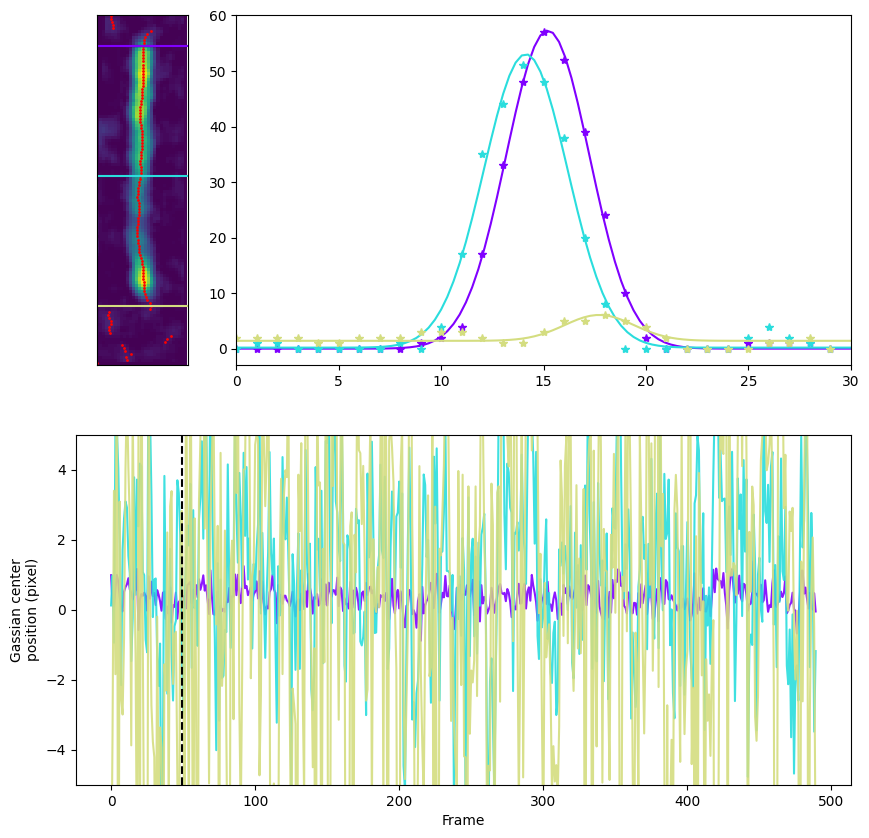

In [46]:
plt.close('all')
plt.close('all')

fig_2 = plt.figure(figsize=(10, 10))

# create a grid with two rows and two columns
gs = fig_2.add_gridspec(2, 5)

# create the subplots within the new grid
axs = [fig_2.add_subplot(gs[0, 0]),
       fig_2.add_subplot(gs[0, 1:]),
       fig_2.add_subplot(gs[1, :])]

dna_pos = 10
dna_positions = np.linspace(10, img_arr_0_loop.shape[1]-20, 3).astype(int)
mean_dna_axis = df_combined['mu'].mean()

# create a rainbow color map
cmap = plt.get_cmap('rainbow')

for idx, dna_pos in enumerate(dna_positions):
    df_i = df_combined[df_combined['dna_pos'] == dna_pos]
    df_i['mu'] = df_i['mu'] - mean_dna_axis
    axs[2].plot(df_i['frame'].values, df_i['mu'].values,
                color=cmap(idx/len(dna_positions)),
                alpha=0.9,)
axs[2].set_ylim(-5, 5)
line_frame = axs[2].axvline(x=dna_positions[0], color='k', linestyle='--')


# axs[1].set_title(f'Plot for frame = {i}')
axs[2].set_xlabel('Frame')
axs[2].set_ylabel('Gassian center\nposition (pixel)')


def update(i):
    image = img_arr_0_loop[i, ::]
    # Clear the previous plot
    axs[0].cla()
    axs[0].imshow(image)
    df_i = df_combined[df_combined['frame'] == i]
    axs[0].scatter(df_i['mu'], df_i['dna_pos'], c='r', s=1)
    axs[1].cla()
    for idx, dna_pos in enumerate(dna_positions):
        axs[0].axhline(y=dna_pos, color=cmap(idx/len(dna_positions)))
        frame, _, mu, sigma, amplitude, background = df_i[df_i['dna_pos'] == dna_pos].values[0]
        y = image[dna_pos, :]
        x = np.arange(0, len(y), 1)
        # Plot the new data
        axs[1].plot(x, y, '*', color=cmap(idx/len(dna_positions)))
        # Fit the data to the Gaussian function
        x = np.linspace(0, len(y), 100)
        axs[1].plot(x, gaussian_bg(x, mu, sigma, amplitude, background), '-', color=cmap(idx/len(dna_positions)))
        # axs[1].axvline(x=mu, color=cmap(idx/len(dna_positions)))
        line_frame.set_xdata(i)
        axs[0].set_xlim([0, len(y)])
        axs[1].set_xlim([0, len(y)])
        # set some axis parameters
        axs[0].set_xticks([])
        axs[0].set_yticks([])
        axs[0].set_xticklabels([])
        axs[0].set_yticklabels([])

ani = FuncAnimation(fig_2, update, frames=50, interval=100)# frames=img_arr_0_loop.shape[0]
ani.save('animation_frames.mp4')


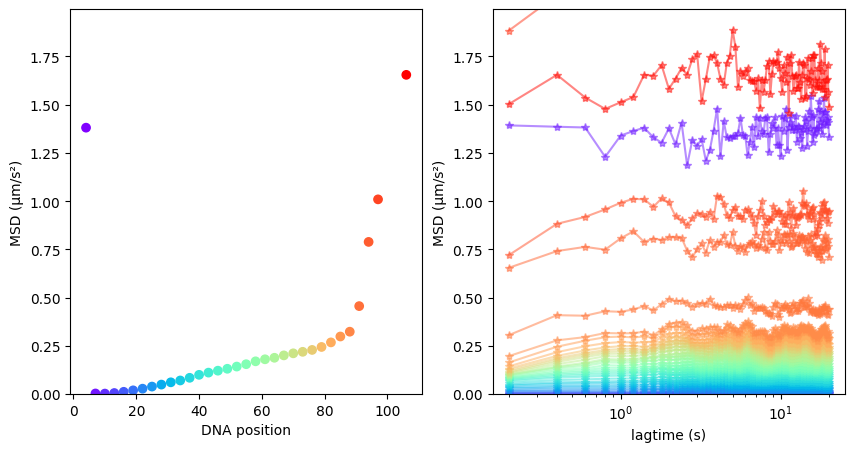

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


dna_pos = 30
cmap = plt.get_cmap('rainbow')
skip_dna_pixs = 3 # skip every 5 pixels
start_dna_pix = 4
dna_half_width = int(-start_dna_pix+img_arr_0_loop.shape[1]-start_dna_pix)
dna_pos_list = []
msd_list = [] # at lagtime = 3 e.g.
msd_at = 6
pixel_size = 0.105
fps = 5
max_lagtime = 100

# plot the second subplot
for i in range(start_dna_pix, dna_half_width, skip_dna_pixs):
    dna_pos = i
    df_i = df_combined[df_combined['dna_pos'] == dna_pos]
    df_i['particle'] = 1
    df_i['x'] = df_i['mu']
    df_i['y'] = 1
    imsd = tp.imsd(df_i, mpp=pixel_size, fps=fps, max_lagtime=max_lagtime)
    dna_pos_list.append(dna_pos)
    msd_list.append(imsd.iloc[msd_at, 0])# at lagtime = 3 e.g.
    axs[1].plot(imsd.index.values, imsd.iloc[:, 0].values, '-*',
             color=cmap(i/dna_half_width), alpha=0.5,
             label=f'dna_pos = {dna_pos}')
    axs[1].set_xscale('log')
    axs[1].set_xlabel('lagtime (s)')
    axs[1].set_ylabel('MSD (µm/s²)')

# plot the first subplot
axs[0].scatter(dna_pos_list, msd_list, c=dna_pos_list, cmap='rainbow')

axs[0].set_ylim([0, 2.5*np.mean(msd_list)])
axs[1].set_ylim([0, 2.5*np.mean(msd_list)])

axs[0].set_xlabel('DNA position')
axs[0].set_ylabel('MSD (µm/s²)')

plt.show()


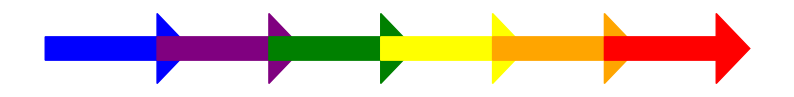

In [48]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 1))
ax.axis('off')
ax.arrow(0, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='blue')
ax.arrow(1, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='purple')
ax.arrow(2, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='green')
ax.arrow(3, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='yellow')
ax.arrow(4, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='orange')
ax.arrow(5, 0, 1, 0, width=0.1, head_width=0.3, head_length=0.3, color='red')
plt.show()


In [49]:
print(imsd[:20])

                     1
lag time [s]          
0.2           1.502475
0.4           1.654245
0.6           1.536811
0.8           1.477786
1.0           1.512271
...                ...
19.2          1.627337
19.4          1.631427
19.6          1.705137
19.8          1.566746
20.0          1.489651

[100 rows x 1 columns]
